In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import mpmath as mp

In [2]:
%matplotlib inline

In [3]:
def mperSite(J):
    Jc = 0.5*np.log(1+np.sqrt(2))
    if J <= Jc:
        return 0
    else:
        return (1 - (1)/(mp.sinh(2*J)**4))**(1/8)
    
def epsilon(J):
    m = (4*mp.sech(2*J)**2*mp.tanh(2*J)**2)**2
    e = -J*mp.coth(2*J)*(1 + (2)/(np.pi)*(2*mp.tanh(2*J)**2 - 1) * mp.ellipk(m))
    return e

Jinv = 3
J = 1/Jinv

print(epsilon(J))

-0.307056009838703


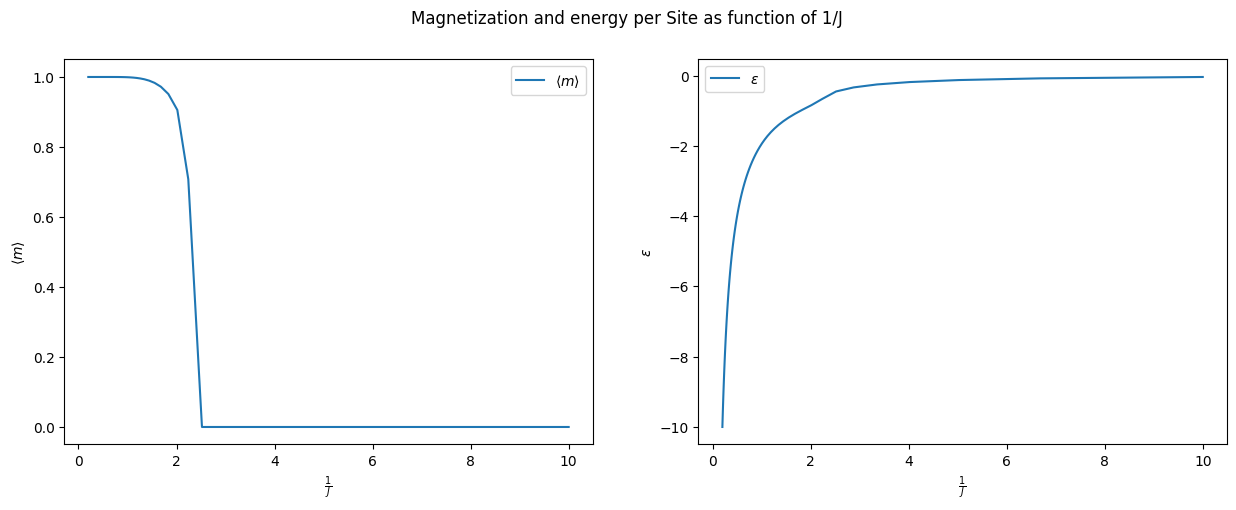

In [4]:
J_val = np.linspace(0.1,5,100)

m = np.zeros(len(J_val))
e = np.zeros(len(J_val))

for i in range(len(J_val)):
    m[i] = mperSite(J_val[i])
    e[i] = epsilon(J_val[i])

fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(1/J_val, m, label=r'$\langle m \rangle$')
ax[1].plot(1/J_val, e, label=r'$\epsilon$')

ax[0].set_xlabel(r'$\frac{1}{J}$')
ax[1].set_xlabel(r'$\frac{1}{J}$')
ax[0].set_ylabel(r'$\langle m \rangle$')
ax[1].set_ylabel(r'$\epsilon$') 
ax[0].legend()
ax[1].legend()
fig.suptitle('Magnetization and energy per Site as function of 1/J')
fig.savefig('5_1.png')



In [5]:
def hamiltonian2d(J, sigma):
    H = 0
    N = sigma.shape[0]

    
    for i in range(N):
        for j in range(N):
            H -= J * sigma[i,j] * (sigma[(i+1)%N, j] + sigma[i, (j+1)%N])
            
    return H

def del_hamiltonian(J, sigma, x):
    
    N = sigma.shape[0]
    i, j = x
    spin = sigma[i,j]
    
    neighbors = [sigma[(i-1)%N, j],
                 sigma[(i+1)%N, j], 
                 sigma[i, (j-1)%N], 
                 sigma[i, (j+1)%N]]
    
    current_energy = -J * spin * sum(neighbors)
    
    new_energy = -J * (-spin) * sum(neighbors)
    
    delta_H = new_energy - current_energy
    
    return delta_H

def metropolis_hastings(J, sigma, num_sweeps):
    
    N = sigma.shape[0]
    
    for sweep in range(num_sweeps):
        for _ in range(N * N):
            i, j = np.random.randint(0, N), np.random.randint(0, N)
            
            delta_H = del_hamiltonian(J, sigma, (i, j))
            
            if delta_H < 0 or np.random.rand() < np.exp(-delta_H): 
                sigma[i, j] *= -1
            
    return sigma



In [6]:
def gen_ensemble(J, N, num_cfg, num_sweeps):
    
    ensemble = []
   
    
    for _ in range(num_cfg):
        sigma = np.random.choice([-1, 1], size=(N,N))
        
        sigma = metropolis_hastings(J, sigma, num_sweeps)
        
        ensemble.append(np.copy(sigma))
        
        
    return ensemble

def eval_ensemble(J, sigma):
    m = []
    m_abs = []
    e = []
    
    for i in range(len(sigma)):
        m.append(np.mean(sigma[i]))
        m_abs.append(abs(np.mean(sigma[i])))
        e.append(hamiltonian2d(J, sigma[i]))
    
    return m, m_abs, e 

In [7]:
N_val = [4, 8, 12]
num_cfg = 10*5
num_sweeps = 1
J = 0.5



for i in range(len(N_val)): 
    if i == 0:
        ensemble4 = np.array(gen_ensemble(J,N_val[i],num_cfg,num_sweeps))
        print(i)
    if i == 1:
        ensemble8 = np.array(gen_ensemble(J,N_val[i],num_cfg,num_sweeps))
        print(i)
    if i == 2:
        ensemble12 = np.array(gen_ensemble(J,N_val[i],num_cfg,num_sweeps))
        print(i)
    
    
         

0
1
2


In [8]:
m1, m_abs1, e1 = eval_ensemble(J, ensemble4)
m2, m_abs2, e2 = eval_ensemble(J, ensemble8)    
m3, m_abs3, e3 = eval_ensemble(J, ensemble12)

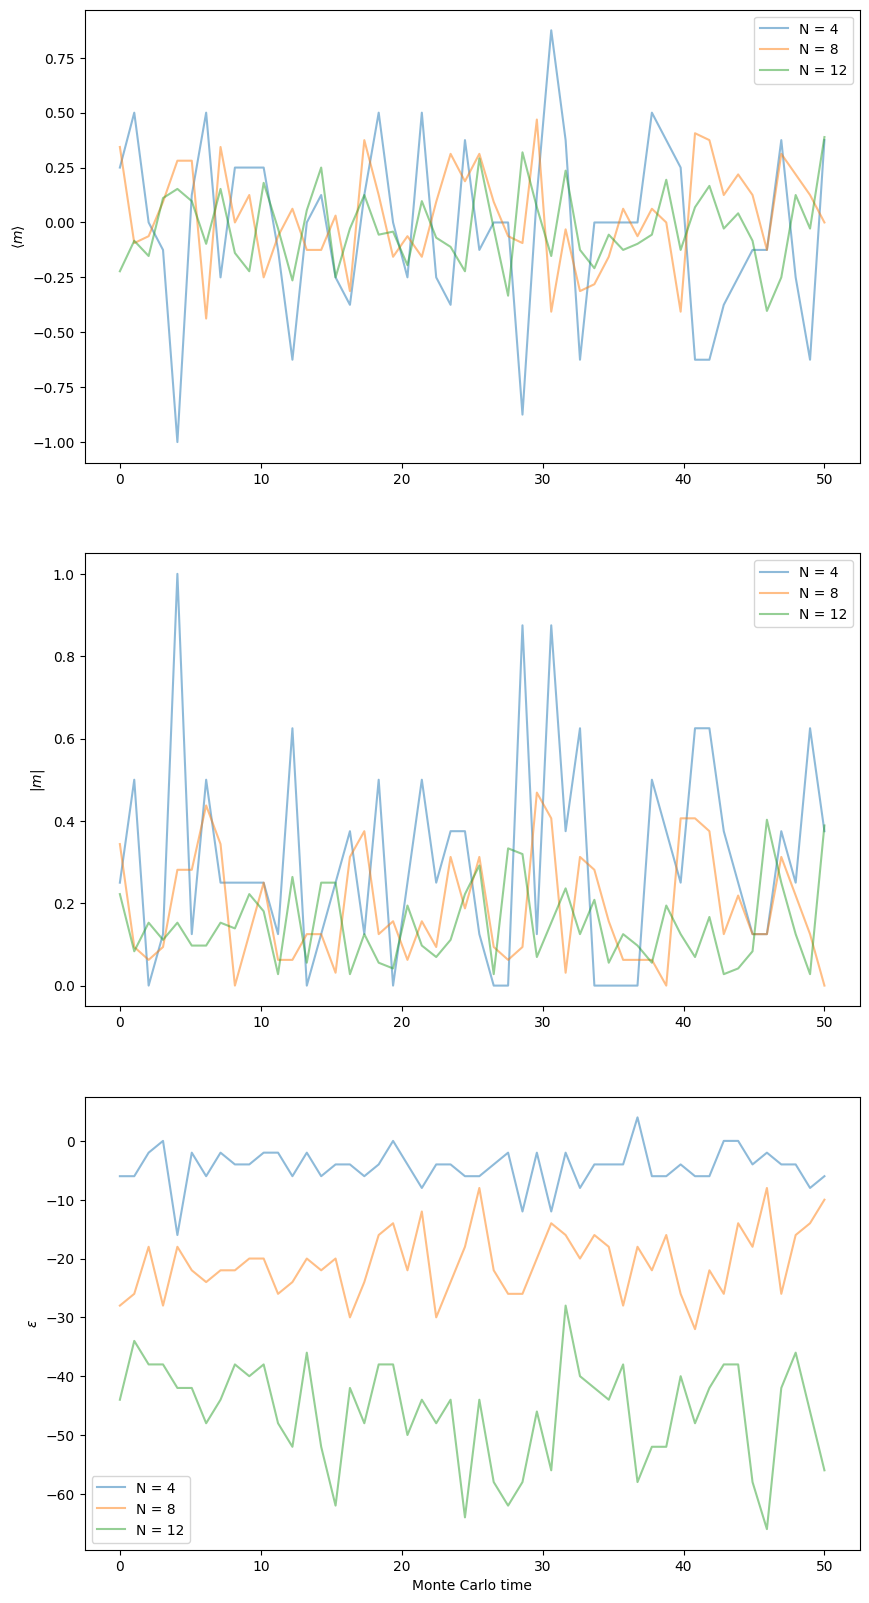

In [9]:
t = np.linspace(0,num_cfg, num_cfg)

fig, ax = plt.subplots(3, figsize=(10,20))

ax[0].plot(t, m1, alpha=0.5, label=f'N = {N_val[0]}')
ax[0].plot(t, m2, alpha=0.5, label=f'N = {N_val[1]}')
ax[0].plot(t, m3, alpha=0.5, label=f'N = {N_val[2]}')
ax[1].plot(t, m_abs1, alpha=0.5, label=f'N = {N_val[0]}')
ax[1].plot(t, m_abs2, alpha=0.5, label=f'N = {N_val[1]}')
ax[1].plot(t, m_abs3, alpha=0.5, label=f'N = {N_val[2]}')
ax[2].plot(t, e1, alpha=0.5, label=f'N = {N_val[0]}')
ax[2].plot(t, e2, alpha=0.5, label=f'N = {N_val[1]}')
ax[2].plot(t, e3, alpha=0.5, label=f'N = {N_val[2]}')
ax[2].set_xlabel('Monte Carlo time')
ax[0].set_ylabel(r'$\langle m \rangle$')
ax[1].set_ylabel(r'$|m|$')
ax[2].set_ylabel(r'$\epsilon$')
ax[0].legend()
ax[1].legend()
ax[2].legend()
fig.savefig('5_2.png')

In [10]:
def autocorr_function(time_series):
    n = len(time_series)
    mean = np.mean(time_series)
    
    autocorr = np.correlate(time_series - mean, time_series - mean, mode='full')
    autocorr = autocorr[n-1:]
    
    return autocorr / autocorr[0]

def autocorr_time(gamma, T):
    
    return 0.5 + np.sum(gamma[1:T+1])

In [11]:
gamma_m1 = autocorr_function(m1)
tau_m1 = autocorr_time(gamma_m1,50)
gamma_mabs1 = autocorr_function(m_abs1)
tau_mabs1 = autocorr_time(gamma_mabs1,50)
gamma_e1 = autocorr_function(e1)
tau_e1 = autocorr_time(gamma_e1,50)
print(f'tau for m1 is {tau_m1}')
print(f'tau for mabs1 is {tau_mabs1}')
print(f'tau for e1 is {tau_e1}')

gamma_m2 = autocorr_function(m2)
tau_m2 = autocorr_time(gamma_m2,50)
gamma_mabs2 = autocorr_function(m_abs2)
tau_mabs2 = autocorr_time(gamma_mabs2,50)
gamma_e2 = autocorr_function(e2)
tau_e2 = autocorr_time(gamma_e2,50)
print(f'tau for m2 is {tau_m2}')
print(f'tau for mabs2 is {tau_mabs2}')
print(f'tau for e2 is {tau_e2}')

gamma_m3 = autocorr_function(m3)
tau_m3 = autocorr_time(gamma_m3,50)
gamma_mabs3 = autocorr_function(m_abs3)
tau_mabs3 = autocorr_time(gamma_mabs3,50)
gamma_e3 = autocorr_function(e3)
tau_e3 = autocorr_time(gamma_e3,50)
print(f'tau for m3 is {tau_m3}')
print(f'tau for mabs3 is {tau_mabs3}')
print(f'tau for e3 is {tau_e3}')

tau for m1 is 2.220446049250313e-16
tau for mabs1 is -2.220446049250313e-16
tau for e1 is -1.1102230246251565e-16
tau for m2 is 1.1102230246251565e-16
tau for mabs2 is 2.220446049250313e-16
tau for e2 is -3.3306690738754696e-16
tau for m3 is -2.220446049250313e-16
tau for mabs3 is 1.1102230246251565e-16
tau for e3 is 0.0


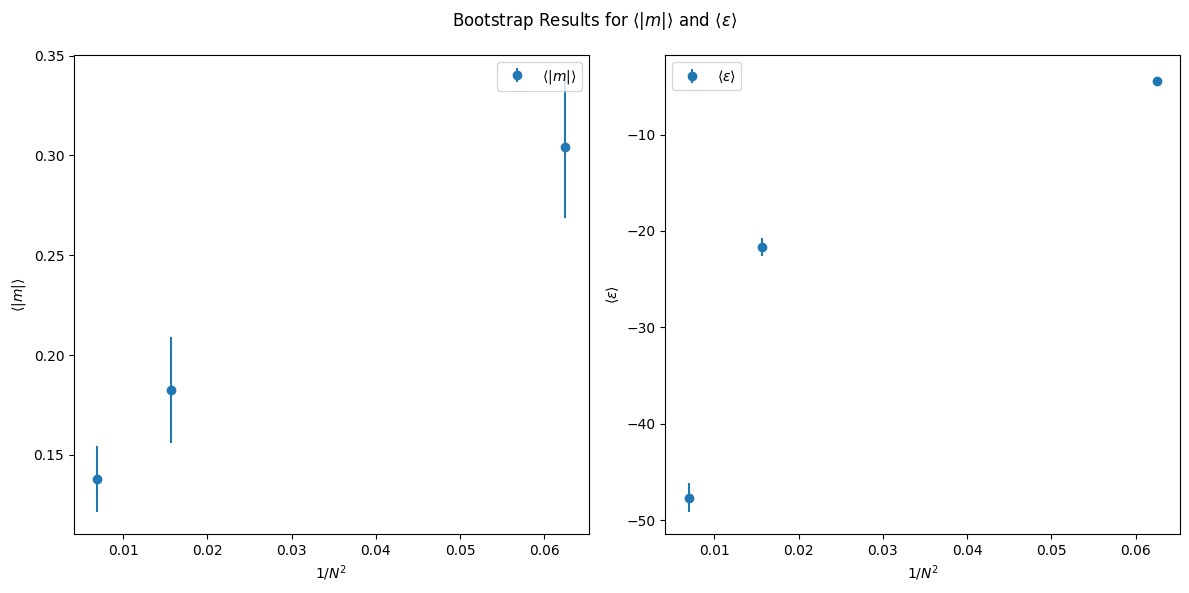

In [15]:

m_abs = [m_abs1, m_abs2, m_abs3] 
epsilon = [e1, e2, e3]          
N_values = np.array([4, 8, 12])


def autocorrelation_time(data):
    n = len(data)
    mean = np.mean(data)
    var = np.var(data)
    acf = np.correlate(data - mean, data - mean, mode='full') / (var * n)
    acf = acf[n - 1:]
    tau = 1 + 2 * np.sum(acf[1:np.argmax(acf < 0)])  
    return tau

def bootstrap_analysis(data, n_resamples=1000):
    means = []
    for _ in range(n_resamples):
        resample = np.random.choice(data, size=len(data), replace=True)
        means.append(np.mean(resample))
    return np.mean(means), np.std(means)


mean_m_abs, std_m_abs = [], []
mean_eps, std_eps = [], []

for m_data, e_data in zip(m_abs, epsilon):
 
    tau_m = autocorrelation_time(m_data)
    tau_e = autocorrelation_time(e_data)
    tau = max(tau_m, tau_e)

 
    blocked_m = m_data[::int(np.ceil(tau))]
    blocked_e = e_data[::int(np.ceil(tau))]


    mean_m, std_m = bootstrap_analysis(blocked_m)
    mean_e, std_e = bootstrap_analysis(blocked_e)

    mean_m_abs.append(mean_m)
    std_m_abs.append(std_m)
    mean_eps.append(mean_e)
    std_eps.append(std_e)


x = 1 / N_values**2

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].errorbar(x, mean_m_abs, yerr=std_m_abs, fmt='o', label=r'$\langle |m| \rangle$')
ax[0].set_xlabel(r'$1/N^2$')
ax[0].set_ylabel(r'$\langle |m| \rangle$')
ax[0].legend()

ax[1].errorbar(x, mean_eps, yerr=std_eps, fmt='o', label=r'$\langle \epsilon \rangle$')
ax[1].set_xlabel(r'$1/N^2$')
ax[1].set_ylabel(r'$\langle \epsilon \rangle$')
ax[1].legend()
plt.suptitle(r'Bootstrap Results for $\langle |m| \rangle$ and $\langle \epsilon \rangle$')

plt.tight_layout()
plt.show()
